In [1]:


import matplotlib.pyplot as plt

from chord import Chord
# load 
import sys
import time

from sklearn.model_selection import cross_val_score,train_test_split
from datetime import date
import numpy as np
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import subprocess
import os 
from scipy.stats import ranksums

from scipy import stats


if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
    
os.chdir(main_fold_path)



output_fold = 'FigureTable/statics/DMFC'

if not os.path.exists(output_fold):
    os.makedirs(output_fold)
    

Current system is macOS


In [55]:
def fdr_fix_p(data):
    shape = data.shape
    num_of_region = shape[0]

    for view in range(shape[-1]):
        uncorrected_p = []
        for i in range(num_of_region):
            for j in range(num_of_region):
                if j<=i:
                    continue
                uncorrected_p.append(data[i,j, view])
        print(f" view: {view}, uncorrected_p: {uncorrected_p}")
        corrected_p = multipletests(uncorrected_p, alpha=0.05, method='fdr_bh')[1]
        print('length of corrected_p:', len(corrected_p))
        count = 0
        for i in range(num_of_region):
            for j in range(num_of_region):
                if j<=i:
                    continue
                else:
                    data[i, j, view] = corrected_p[count]
                    data[j, i, view] = corrected_p[count]
                    print('i:', i, 'j:', j, 'view:', view, 'corrected_p:', corrected_p[count])

                    count += 1
    return data

stats_method = 'mannwhitneyu' # 'ranksums' or 'mannwhitneyu'
def zero_diagnonal(arr):
    # Loop over the first and last dimension
    for i in range(arr.shape[0]):  # Loop over subjects
        for j in range(arr.shape[-1]):  # Loop over views
            np.fill_diagonal(arr[i, :, :, j], 0)
    return arr


def show(adj, labels, fig_path, using_fdr):
    adj = zero_diagnonal(adj)
    hc_adj = adj[np.where(labels==1)]
    md_adj = adj[np.where(labels==0)]
    count = 0

    num_view = adj.shape[-1]
    p_view = np.zeros((52,52,num_view))
    effect_size = np.zeros((52,52,num_view))
    stats = np.zeros((52,52,num_view))
    for view in range(num_view):
        for seed in range(52):
            for target in range(52):
                hc_val = hc_adj[:, seed, target, view]
                md_val = md_adj[:, seed, target, view]
                if stats_method == 'mannwhitneyu':
                    stat, p1 = mannwhitneyu(hc_val,md_val)
                elif stats_method == 'ranksums':
                    stat, p1 = ranksums(hc_val,md_val)
                else:
                    raise ValueError('stats_method should be mannwhitneyu or ranksums')
                p_view[seed, target, view] = p1
                stats[seed, target, view] = stat
                
                # Calculate Hedges' g
                effect_size[seed, target, view] = pg.compute_effsize(hc_val,md_val, eftype='Hedges')
                
    # plt.figure()
    # plt.subplot(1, 3, 1)
    # plt.imshow(stats[:,:,0])
    # plt.colorbar()
    # plt.subplot(1, 3, 2)
    # plt.imshow(stats[:,:,1])
    # plt.colorbar()

    # plt.subplot(1,3,3)
    # plt.imshow(stats[:,:,2])
    # plt.colorbar()

    # plt.show()
    
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import LogNorm


    colors = ['red','white']
    # cmap = LinearSegmentedColormap.from_list('RedToWhite', colors)
    # colors = [(1, 0, 0), (1, 1, 1)]  # Red to White
    # colors = ['#FF0000', '#FF3333', '#FF6666', '#FF9999', '#FFCCCC', '#FFFFFF']
    # Create a colormap with the defined colors
    cmap = LinearSegmentedColormap.from_list('RedToWhite', colors, N=256)


    colors_effect_size = ['blue','white','red']
    # cmap = LinearSegmentedColormap.from_list('RedToWhite', colors)
    # colors = [(1, 0, 0), (1, 1, 1)]  # Red to White
    # colors = ['#FF0000', '#FF3333', '#FF6666', '#FF9999', '#FFCCCC', '#FFFFFF']
    # Create a colormap with the defined colors
    # Define the colors in hexadecimal format
    colors = ['#448196', 'white', '#c45c3d']

    # Create the custom color map
    cmap_effect_size = LinearSegmentedColormap.from_list('CustomColorMap', colors, N=256)

    # cmap_effect_size = LinearSegmentedColormap.from_list('BlueToWhiteToRed', colors_effect_size, N=256)

    # Set up a 2x4 grid for plotting
    fig, axes = plt.subplots(nrows=2, ncols=num_view, figsize=(12, 6))

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    A_adj_name = ['HbO', 'HbR', 'HbT']
    
    if using_fdr:
        p_view = fdr_fix_p(p_view)
        
    # Loop through images and axes to display each image
    for idx, ax in enumerate(axes):
        if idx < num_view: 
            im=ax.imshow(p_view[:,:,idx], norm=LogNorm(vmin=0.001, vmax=0.05), cmap=cmap)
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.05, ticks=[0.001, 0.01, 0.05])
            cbar.ax.set_yticklabels(['0.001', '0.01', '0.05'], fontsize=12, fontweight='bold')

            # ax.colorbar()
        else: 
            im=ax.imshow(effect_size[:,:,idx-num_view], vmin=-1.00, vmax=1.00, cmap=cmap_effect_size)
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.05, ticks=[-1.00, -0.5, 0, 0.5, 1.00])
            cbar.ax.set_yticklabels(['-1.00', '-0.5', '0', '0.5', '1.00'], fontsize=12, fontweight='bold')

            # ax.colorbar()
        # ax.axis('off')  # Turn off axis
        ax.set_title(f'{A_adj_name[idx%num_view]}',fontsize=13, fontweight='bold')  # Set title for each subplot
            # Set axis ticks
        ax.set_xticks([0, 25, 51])
        ax.set_yticks([0, 25, 51])

        # Set axis tick labels
        ax.set_xticklabels([1, 26, 52], fontsize=12, fontweight='bold')
        ax.set_yticklabels([1, 26, 52], fontsize=12, fontweight='bold')
        
        ax.set_xlabel('Channels', fontsize=12, fontweight='bold')
        ax.set_ylabel('Channels', fontsize=12, fontweight='bold')
        # fig.colorbar(im, ax=ax)  # Add colorbar for each subplot

        plt.tight_layout()
        
        # Remove spines for effect size
        if idx>=num_view:
            for spine in ax.spines.values():
                spine.set_visible(False)
        else:
            for spine in ax.spines.values():
                spine.set_linewidth(0.5)  # 设置边框的厚度为0.5

    # plt.savefig('/figures/connectivity.png')
    plt.savefig(output_fold+f'/{fig_path}')

    plt.show()            

In [58]:
data_path = 'allData/prognosis/pretreatment_response/hb_data.npy'

pre_treatment_hb = np.load(data_path)
data_shape = pre_treatment_hb.shape
pre_treatment_hbo = np.load(data_path)[..., :data_shape[-1]//2]
pre_treatment_hbr = np.load(data_path)[..., data_shape[-1]//2:]

labels = np.load('allData/prognosis/pretreatment_response/label.npy')

def compute_correlation(x, y, method='pearsonr'):
    if method == 'pearsonr':
        corr, _ = stats.pearsonr(x, y)
    else:
        # raise
        raise ValueError('Method not supported')
    return corr


def compute_fc(data):
    dm_data = data
    feature_shape = dm_data.shape
    if feature_shape[1] != 52:
        raise ValueError(
            'The shape of feature_shape should be (subject, 52, time)')
    else:
        print(
            "Nice, the feature_shape is correct, its shape[1] is 52 (channel)")

    dmfc = np.zeros((dm_data.shape[0], dm_data.shape[1], dm_data.shape[1]))
    for sub in range(feature_shape[0]):
        for ch_1 in range(feature_shape[1]):
            for ch_2 in range(feature_shape[1]):
                if ch_2 < ch_1:
                    continue
                corr = compute_correlation(
                    dm_data[sub, ch_1], dm_data[sub, ch_2])
                dmfc[sub, ch_1, ch_2] = corr
                dmfc[sub, ch_2, ch_1] = corr
    return dmfc

def compute_functional_connectivity(input, compute_period):
    """
    
    input is an array like (n_subject, n_channel, n_time)
    
    cmpute_period is a np.arange like (start, end)
    """
    hb = input[..., compute_period]
    hb = compute_fc(hb)
    #test 
    return hb
    
pre_period = np.arange(0, 100)
task_period = np.arange(100, 700)
post_period = np.arange(700, 1250)
all_period = np.arange(0, 1250)

# period = 'task_period'
# hbo_period = compute_functional_connectivity(pre_treatment_hbo, task_period)
# hbr_period = compute_functional_connectivity(pre_treatment_hbr, task_period)


pre_task_period [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Nice, the feature_shape is correct, its shape[1] is 52 (channel)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Nice, the feature_shape is correct, its shape[1] is 52 (channel)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


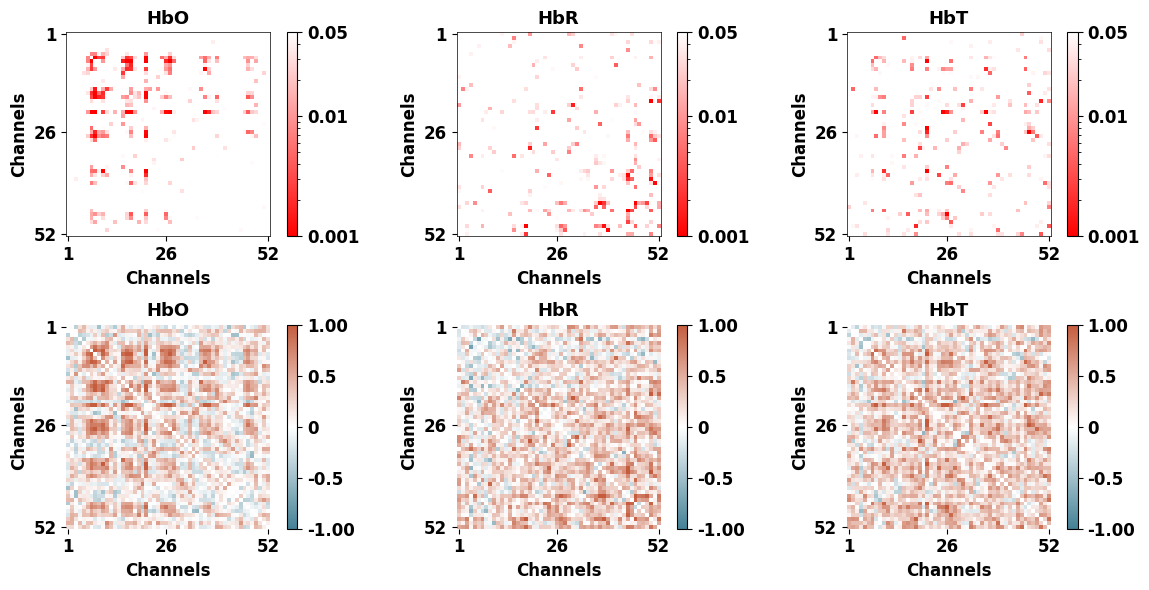

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


 view: 0, uncorrected_p: [0.7762551742013383, 0.3179066536160722, 0.5318098953752997, 0.1803064919895897, 0.8902078322595463, 0.9030565540958166, 0.9676144956436225, 0.1649749928597093, 0.8012557624716161, 0.25223807037222545, 0.6434760999348059, 0.25223807037222545, 0.7148104103008415, 0.07535527741287107, 0.7514842838811386, 0.8646000117124245, 0.9805652810254862, 0.7638395140314798, 0.65516102081061, 0.7391924318604247, 0.9417419384157478, 0.8012557624716161, 0.49006455497822254, 0.5752850610790101, 0.6203711393196571, 0.9159307161619303, 0.4121435348151047, 0.9159307161619303, 0.9805652810254862, 0.4121435348151047, 0.7887282699123148, 0.8391336178937686, 0.27298698448427516, 0.7027258866000989, 0.6434760999348059, 0.5212071571131612, 0.8138345711826565, 0.5533382442003637, 0.4214621429433665, 0.6434760999348059, 0.05849406339520981, 0.3588449836933627, 0.24557262985719663, 0.1649749928597093, 0.24557262985719663, 0.9030565540958166, 0.5107143005069632, 0.4121435348151047, 0.643476

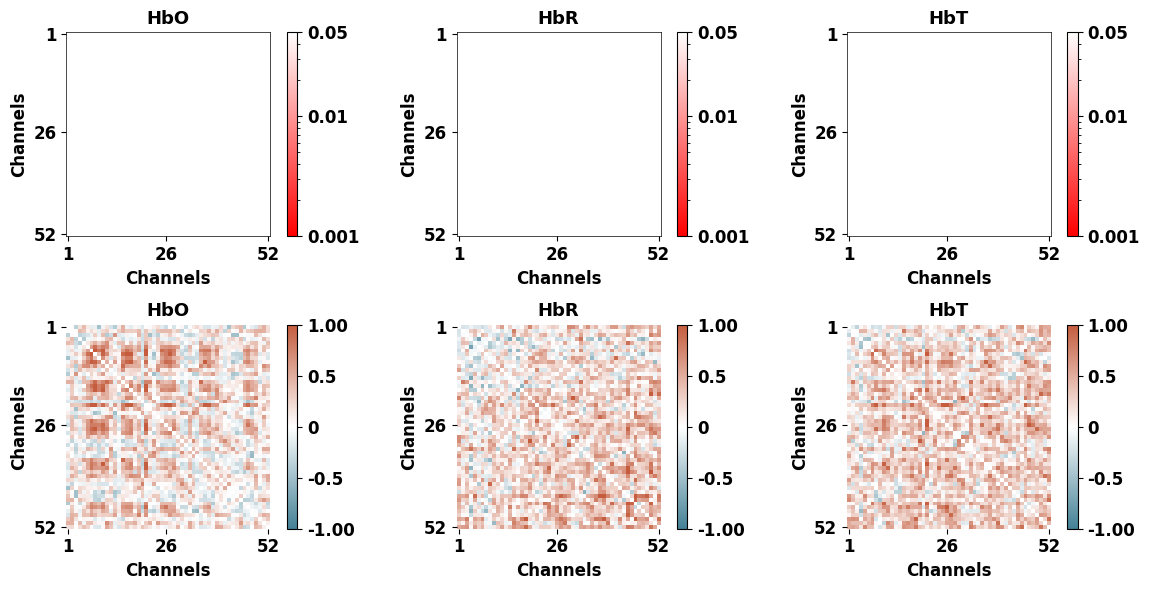

task_period [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 339 340 341 342 34

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


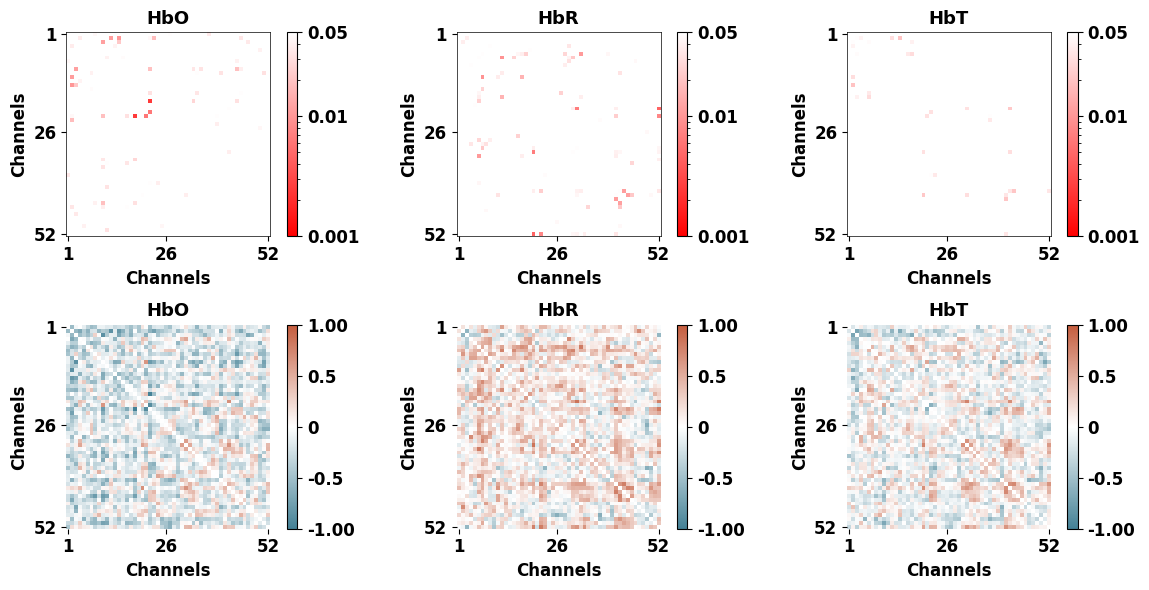

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


 view: 0, uncorrected_p: [0.08967867730350451, 0.6318786793948825, 0.9546722464345138, 0.5425208407390723, 0.2140996829743359, 0.06295678429424348, 0.04489276222468074, 0.5976348914439633, 0.4698725472035453, 0.33389978229837936, 0.5642602829459845, 0.31010151476682857, 0.2874512648810633, 0.45995157724032965, 0.1248590890667605, 0.12091754348186592, 0.19667194825714396, 0.052295004233936335, 0.9159307161619303, 0.8391336178937686, 0.0780598859871921, 0.5318098953752997, 0.47991063833208447, 0.3674139325086885, 0.08967867730350451, 0.04847533294929048, 0.3674139325086885, 0.6669309976137883, 0.9676144956436225, 0.7638395140314798, 0.678783523120638, 0.6434760999348059, 0.0701755110666489, 0.3504027751182819, 0.3588449836933627, 0.035457138544640235, 0.3938769466591322, 0.6203711393196571, 0.5318098953752997, 0.2140996829743359, 0.7762551742013383, 0.7391924318604247, 0.450148947563217, 0.24557262985719663, 0.9935211908132168, 0.27298698448427516, 0.47991063833208447, 0.7148104103008415

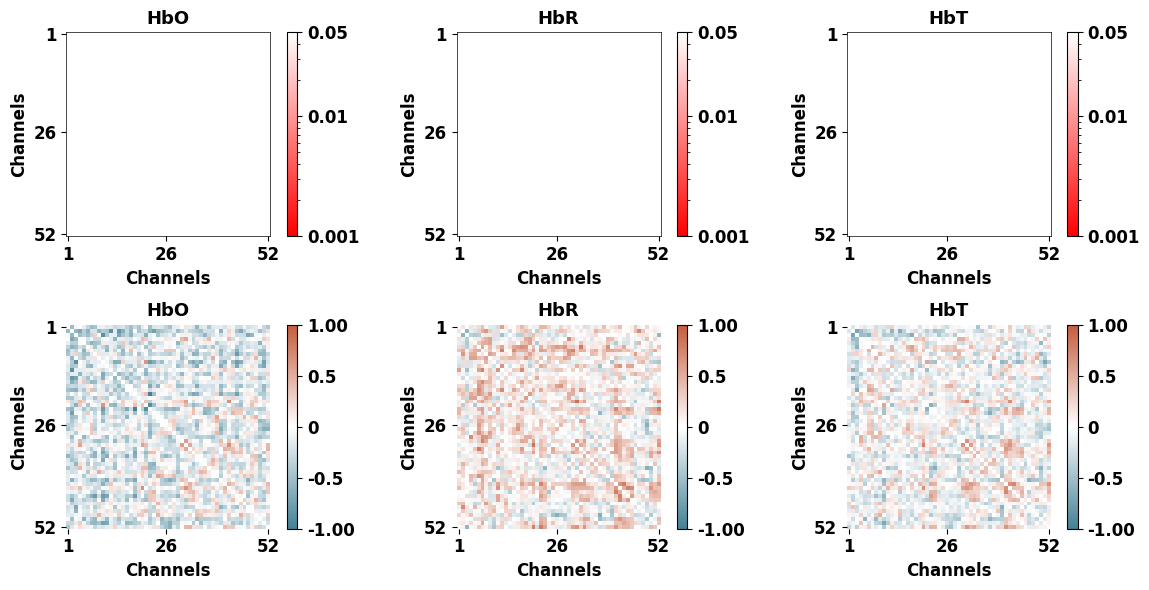

post_task_period [ 700  701  702  703  704  705  706  707  708  709  710  711  712  713
  714  715  716  717  718  719  720  721  722  723  724  725  726  727
  728  729  730  731  732  733  734  735  736  737  738  739  740  741
  742  743  744  745  746  747  748  749  750  751  752  753  754  755
  756  757  758  759  760  761  762  763  764  765  766  767  768  769
  770  771  772  773  774  775  776  777  778  779  780  781  782  783
  784  785  786  787  788  789  790  791  792  793  794  795  796  797
  798  799  800  801  802  803  804  805  806  807  808  809  810  811
  812  813  814  815  816  817  818  819  820  821  822  823  824  825
  826  827  828  829  830  831  832  833  834  835  836  837  838  839
  840  841  842  843  844  845  846  847  848  849  850  851  852  853
  854  855  856  857  858  859  860  861  862  863  864  865  866  867
  868  869  870  871  872  873  874  875  876  877  878  879  880  881
  882  883  884  885  886  887  888  889  890  891  892  893

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


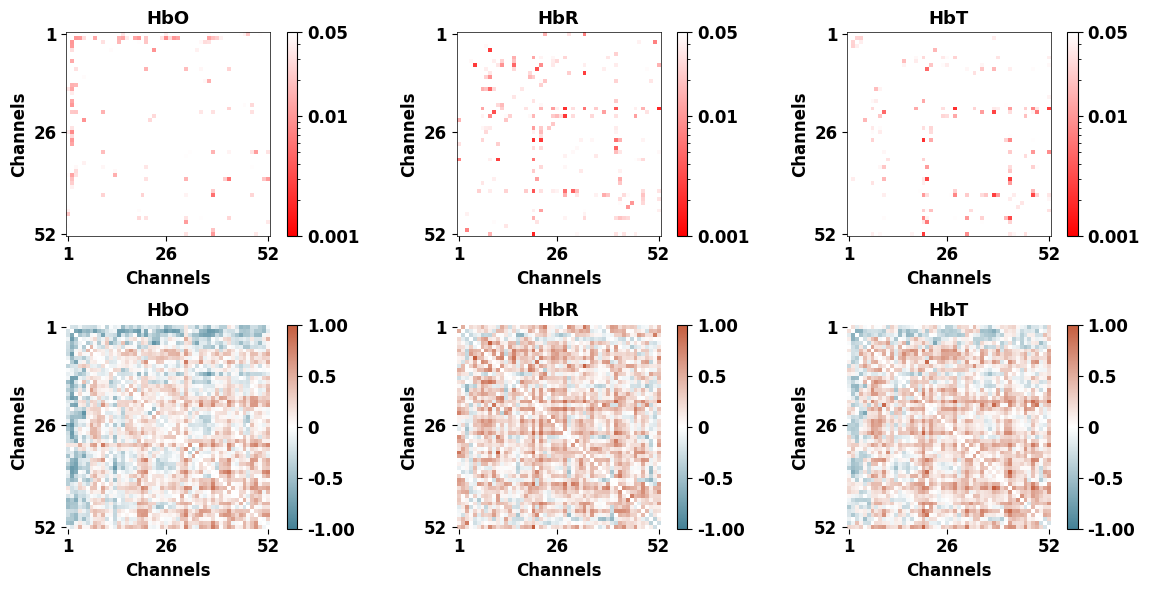

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


 view: 0, uncorrected_p: [0.45995157724032965, 0.4309032026610935, 0.5425208407390723, 0.15531307716221243, 0.3938769466591322, 0.28015570594386396, 0.20236185661449912, 0.58641061042859, 0.8138345711826565, 0.1600889325783421, 0.9676144956436225, 0.7027258866000989, 0.678783523120638, 0.034061837161303454, 0.19667194825714396, 0.0780598859871921, 0.28015570594386396, 0.1372861978931427, 0.450148947563217, 0.4214621429433665, 0.47991063833208447, 0.5107143005069632, 0.29487394756360574, 0.25223807037222545, 0.03839446596326448, 0.06529157930080086, 0.22014940835603924, 0.30242397761775397, 0.28015570594386396, 0.8391336178937686, 0.31010151476682857, 0.3179066536160722, 0.0701755110666489, 0.3674139325086885, 0.07535527741287107, 0.04665511392899979, 0.4121435348151047, 0.4121435348151047, 0.08967867730350451, 0.1803064919895897, 0.9030565540958166, 0.8391336178937686, 0.342087625511844, 0.04847533294929048, 0.041536117100655544, 0.020655623003203297, 0.25223807037222545, 0.18030649198

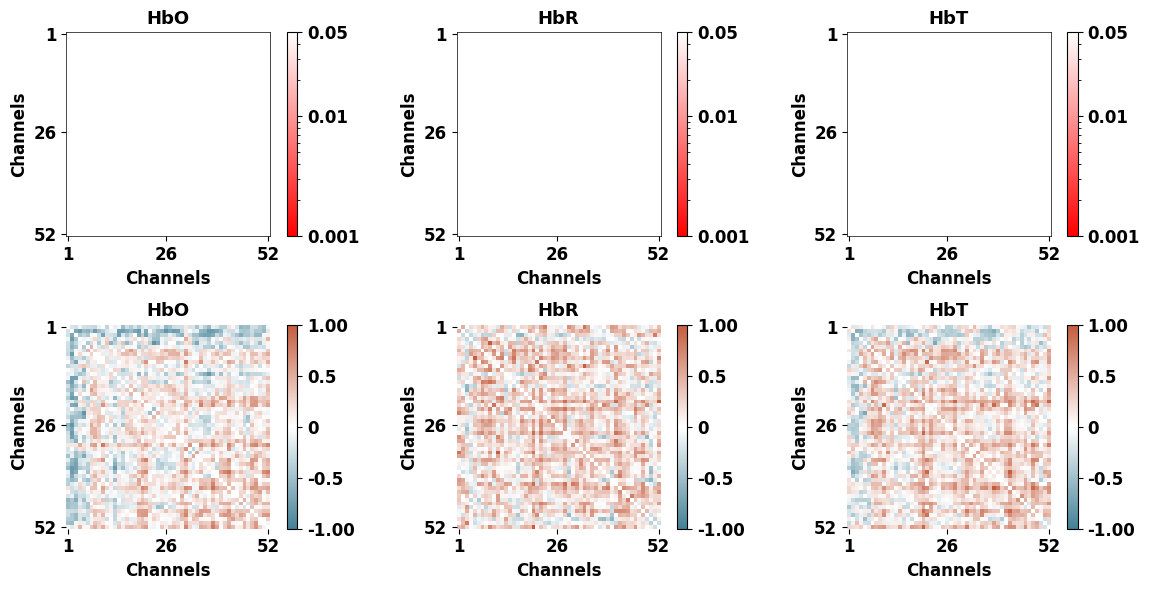

all_period [   0    1    2 ... 1247 1248 1249]
Nice, the feature_shape is correct, its shape[1] is 52 (channel)
Nice, the feature_shape is correct, its shape[1] is 52 (channel)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


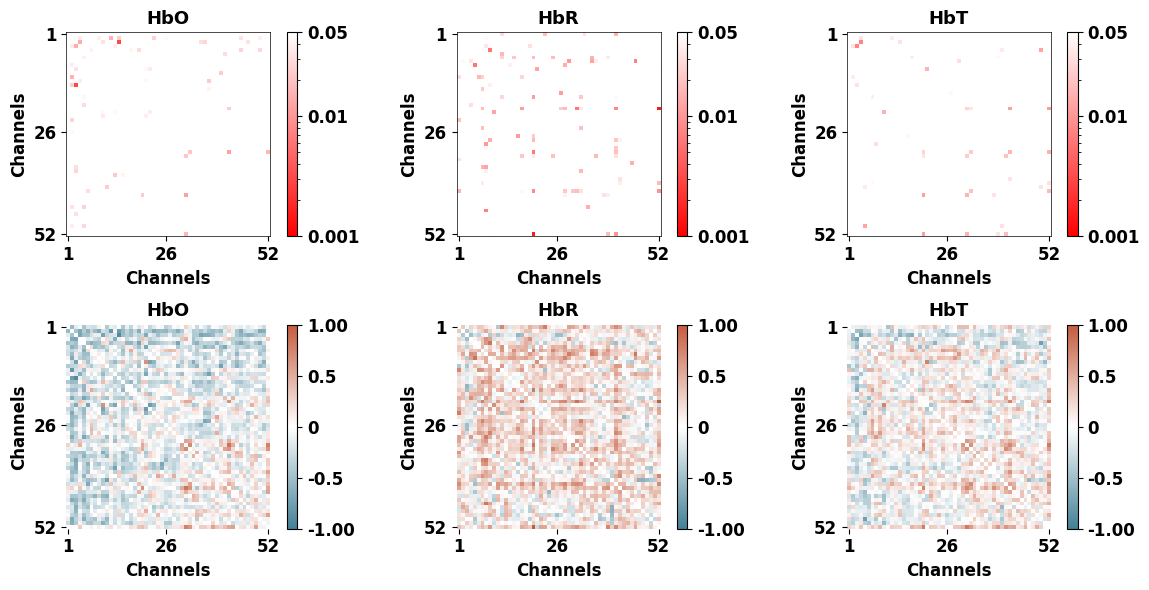

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


 view: 0, uncorrected_p: [0.060691441105220185, 0.58641061042859, 0.678783523120638, 0.08967867730350451, 0.31010151476682857, 0.27298698448427516, 0.3504027751182819, 0.9546722464345138, 0.8518475051169965, 0.09927580584723196, 0.8138345711826565, 0.5533382442003637, 0.65516102081061, 0.060691441105220185, 0.4309032026610935, 0.1600889325783421, 0.8264615756096982, 0.3674139325086885, 0.8646000117124245, 0.9546722464345138, 0.23261465629525002, 0.5642602829459845, 0.9159307161619303, 0.342087625511844, 0.0780598859871921, 0.22014940835603924, 0.7148104103008415, 0.9546722464345138, 0.9546722464345138, 0.4309032026610935, 0.6669309976137883, 0.9805652810254862, 0.29487394756360574, 0.5107143005069632, 0.3588449836933627, 0.1600889325783421, 0.7027258866000989, 0.9417419384157478, 0.4121435348151047, 0.49006455497822254, 0.5318098953752997, 0.7027258866000989, 0.7269668576165321, 0.5107143005069632, 0.608955794172276, 0.342087625511844, 0.5533382442003637, 0.6318786793948825, 0.91593071

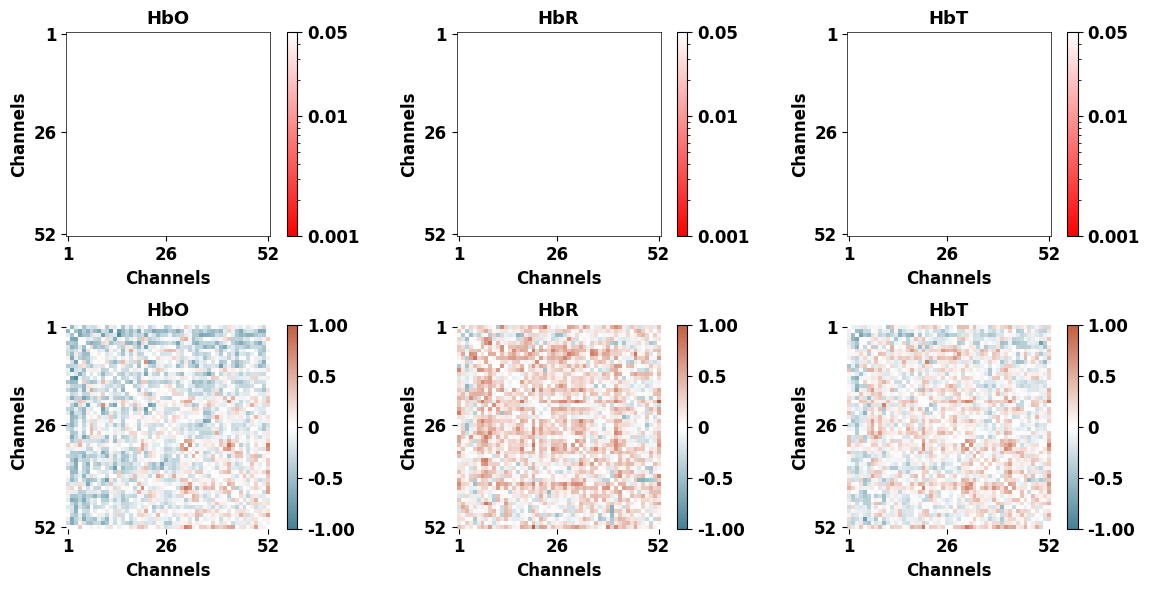

In [60]:
four_period_name = ['pre_task_period', 'task_period', 'post_task_period', 'all_period']
four_period_data = [pre_period, task_period, post_period, all_period]

for period_name, period_data in zip(four_period_name, four_period_data):
    print(period_name, period_data)
    hbo_period = compute_functional_connectivity(pre_treatment_hbo, period_data)
    hbr_period = compute_functional_connectivity(pre_treatment_hbr, period_data)
    for using_fdr in [False, True]:
        hbo_period = np.nan_to_num(hbo_period)
        hbr_period = np.nan_to_num(hbr_period)
        time = 'pre_treatment'
        adj = np.concatenate((hbo_period[..., np.newaxis], hbr_period[..., np.newaxis], hbo_period[..., np.newaxis]+hbr_period[..., np.newaxis]), axis=-1)
        with_fdr_name = 'w' if using_fdr else 'wo'
        fig_path = f'{time}_{period_name}_{stats_method}_{with_fdr_name}_fdr.png'
        show(adj, labels, fig_path, using_fdr=using_fdr)

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


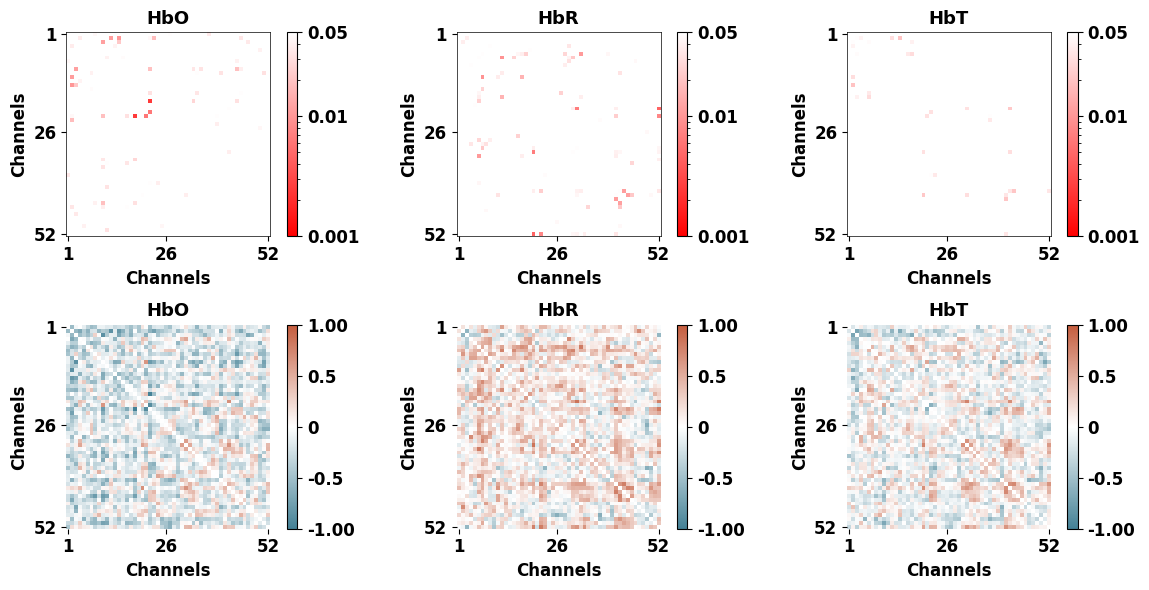

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


 view: 0, uncorrected_p: [0.08967867730350451, 0.6318786793948825, 0.9546722464345138, 0.5425208407390723, 0.2140996829743359, 0.06295678429424348, 0.04489276222468074, 0.5976348914439633, 0.4698725472035453, 0.33389978229837936, 0.5642602829459845, 0.31010151476682857, 0.2874512648810633, 0.45995157724032965, 0.1248590890667605, 0.12091754348186592, 0.19667194825714396, 0.052295004233936335, 0.9159307161619303, 0.8391336178937686, 0.0780598859871921, 0.5318098953752997, 0.47991063833208447, 0.3674139325086885, 0.08967867730350451, 0.04847533294929048, 0.3674139325086885, 0.6669309976137883, 0.9676144956436225, 0.7638395140314798, 0.678783523120638, 0.6434760999348059, 0.0701755110666489, 0.3504027751182819, 0.3588449836933627, 0.035457138544640235, 0.3938769466591322, 0.6203711393196571, 0.5318098953752997, 0.2140996829743359, 0.7762551742013383, 0.7391924318604247, 0.450148947563217, 0.24557262985719663, 0.9935211908132168, 0.27298698448427516, 0.47991063833208447, 0.7148104103008415

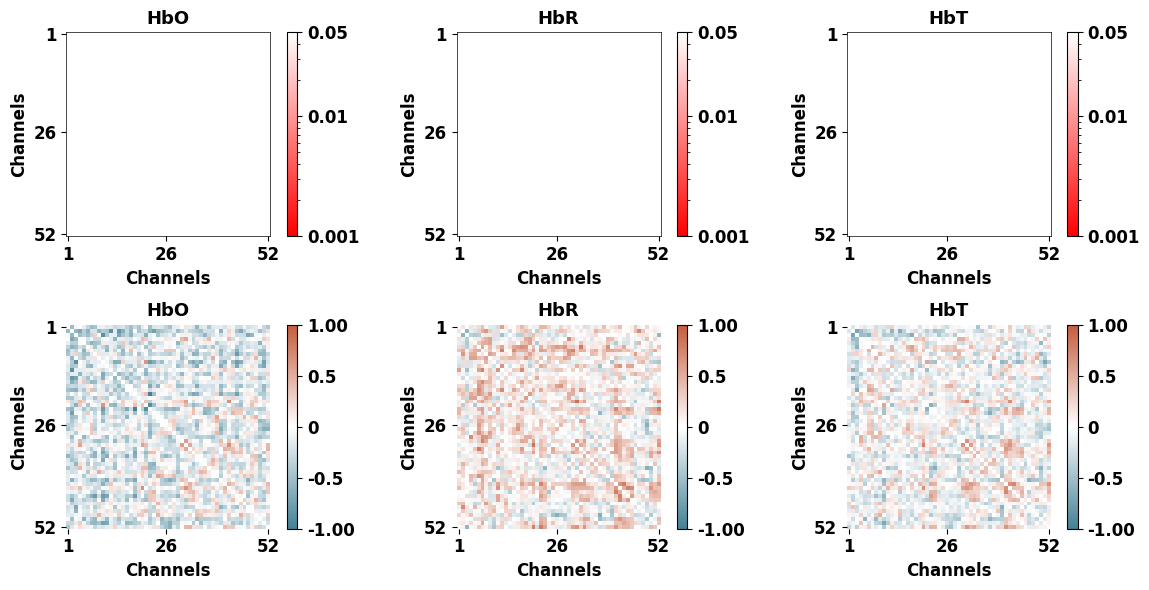

In [56]:

for using_fdr in [False, True]:
    hbo_period = np.nan_to_num(hbo_period)
    hbr_period = np.nan_to_num(hbr_period)
    time = 'pre_treatment'
    adj = np.concatenate((hbo_period[..., np.newaxis], hbr_period[..., np.newaxis], hbo_period[..., np.newaxis]+hbr_period[..., np.newaxis]), axis=-1)
    with_fdr_name = 'w' if using_fdr else 'wo'
    fig_path = f'{time}_{period}_{stats_method}_{with_fdr_name}_fdr.png'
    show(adj, labels, fig_path, using_fdr=using_fdr)
    
    

In [ ]:

time_points = ['pre_treatment'] # , 'post_treatment', 'pre_minus_post_treatment'

pre_dmfc = np.load('allData/prognosis/DMFC/pre_treatment_hamd_reduction_50/data.npy')
pre_label = np.load('allData/prognosis/DMFC/pre_treatment_hamd_reduction_50/label.npy')

pre_post_dmfc = np.load('allData/prognosis/DMFC/pre_post_treatment_hamd_reduction_50/data.npy')
pre_post_label = np.load('allData/prognosis/DMFC/pre_post_treatment_hamd_reduction_50/label.npy')

for time in time_points:
    
    if time == 'pre_treatment':
        adj = pre_dmfc
        labels = pre_label
    elif time == 'post_treatment':
        adj = pre_post_dmfc[...,1]
        labels = pre_post_label
    elif time == 'pre_minus_post_treatment':
        adj = pre_post_dmfc[...,1] - pre_post_dmfc[..., 0]
        labels = pre_post_label
    
    show(adj, labels, time + f"subject_{labels.shape[0]}")

In [11]:
adj.shape

(65, 52, 52, 3)